# Algorithms for Optimizations
## Chapter 5. First-order Methods

In [1]:
%load_ext watermark
%watermark -v -m -p numpy,scipy,matplotlib

Python implementation: CPython
Python version       : 3.8.12
IPython version      : 7.22.0

numpy     : 1.22.4
scipy     : 1.7.1
matplotlib: 3.5.1

Compiler    : GCC 9.4.0
OS          : Linux
Release     : 4.15.0-169-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 16
Architecture: 64bit



In [2]:
import sys
assert sys.version_info >= (3, 7)

In [3]:
import time
import gc
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt

* Rosenbrock function

In [4]:
def rosenbrock(x, b=100):
    return (x[0] - 1)**2 + b * (x[1] - x[0]**2)**2

In [5]:
def rosenbrock_grad(x, b=100):
    return np.array([2 * (x[0] - 1) - 4 * b * (x[1] - x[0]**2) * x[0], 2 * b * (x[1] - x[0]**2)])

In [6]:
def rosenbrock_hess(x, b=100):
    return np.array([[2 - 4 * b * x[1] + 12 * b * x[0]**2, -4 * b * x[0]]\
                     ,[-4 * b * x[0], 2 * b]])

* Line search

In [7]:
# Adpated from Ch 03.
def bracket_minimum(f, x=0, s=1e-2, k=2.0):
    a, ya = x, f(x)
    b, yb = a + s, f(a + s)
    if yb > ya:
        a, b = b, a
        ya, yb = yb, ya
        s = -s
    
    while True:
        c, yc = b + s, f(b + s)
        if yc > yb:
            return (a, c) if a < c else (c, a)
        a, ya, b, yb = b, yb, c, yc
        s *= k

In [8]:
def line_search(f, x, d):
    objective = lambda alpha: f(x + alpha * d)
    a, b = bracket_minimum(objective)
    alpha = opt.brent(objective, brack=(a, b))
    x_opt = x + alpha * d
    return alpha, x_opt, f(x_opt)

* Abstract class for implementing descent methods

In [9]:
from abc import *

class FirstOrderDescentMethod(metaclass=ABCMeta):
    @abstractmethod
    def step(self, f, f_grad, x, alpha):
        raise NotImplementedError

* Helper function for visualization

In [10]:
def plot_descent(title, x0, f, f_grad, descent_method, eps=1e-2, **kwargs):
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 10)
    ax.set_title(f"{title} on Rosenbrock function", fontsize=20)
    ax.set_xlabel("$x_1$", fontsize=18)
    ax.set_ylabel("$x_2$", fontsize=18)

    x = np.linspace(-2, 2, 800)
    y = np.linspace(-2, 2, 600)
    z = rosenbrock(np.meshgrid(x, y))
    ax.contour(x, y, z, levels=np.logspace(-1, 3, 10), alpha=0.2)

    x_curr = x0
    f_prev, f_curr = -np.inf, 0
    ax.annotate('Initial point ($x_0$)', xy=x_curr, xytext=(-1.5, 0), arrowprops={'arrowstyle': '->', 'color': 'blue'})

    optimizer = descent_method(f, f_grad, x_curr, **kwargs)
    it, tic = 1, time.time()
    while np.abs(f_prev - f_curr) / (np.abs(f_curr) + np.finfo(np.float32).eps) > eps:
        ax.plot(*x_curr, marker='x', markersize=8, color='k')
        x_curr = optimizer.step(f, f_grad, x_curr)

        f_prev = f_curr
        f_curr = f(x_curr)
        it += 1
    
    print(f"[INFO] Estimated time: {time.time() - tic:8.4f}sec; {it:4} iterations")
    print(f"[INFO] Function value is minimized to: {f_curr:.4f}\n\t@ x* = {x_curr}")
    
    ax.annotate('Final point ($x^*$)', xy=x_curr, xytext=(1, 0.5), arrowprops={'arrowstyle': '->', 'color': 'red'})
    plt.show()

#### Gradient descent
* Page 71 (Algorithm 5.1)

In [11]:
class GradientDescent(FirstOrderDescentMethod):
    def __init__(self, f, f_grad, x, alpha):
        self.alpha = alpha
        
    def step(self, f, f_grad, x): 
        return x - self.alpha * f_grad(x)

[INFO] Estimated time:   0.0113sec;   20 iterations
[INFO] Function value is minimized to: 1.0571
	@ x* = [-0.02361991 -0.00908493]


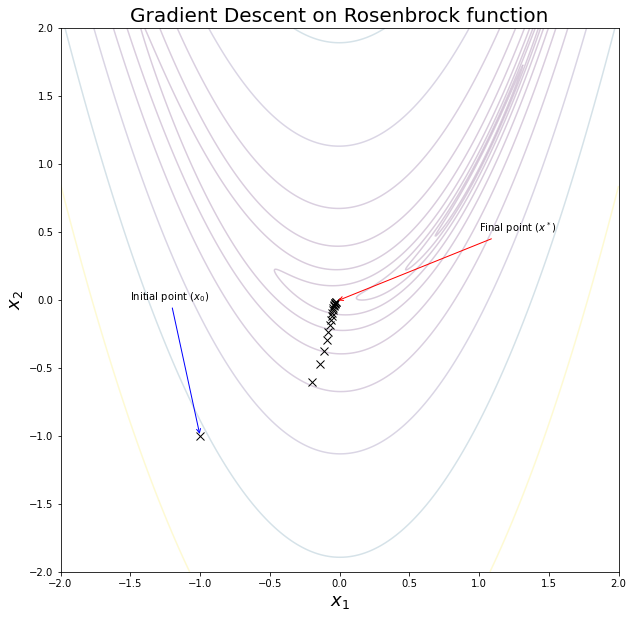

6336

In [12]:
plot_descent(title="Gradient Descent", x0=np.array([-1, -1]), f=rosenbrock, f_grad=rosenbrock_grad, descent_method=GradientDescent, alpha=0.001)
gc.collect()

#### Conjugate gradient descent
* Page 74 (Algorithm 5.2)

In [13]:
class ConjugateGradientDescent(FirstOrderDescentMethod): 
    def __init__(self, f, f_grad, x):
        self.g = f_grad(x)
        self.d = -self.g
        
    def step(self, f, f_grad, x):
        d, g = self.d, self.g
        g_ = f_grad(x)
        beta = max(0., np.dot(g_, g_ - g) / (np.dot(g, g)))
        d_ = -g_ + beta * d
        x_ = line_search(f, x, d_)[1]
        self.d, self.g = d_, g_
        return x_

[INFO] Estimated time:   0.0117sec;   13 iterations
[INFO] Function value is minimized to: 0.0000
	@ x* = [1. 1.]


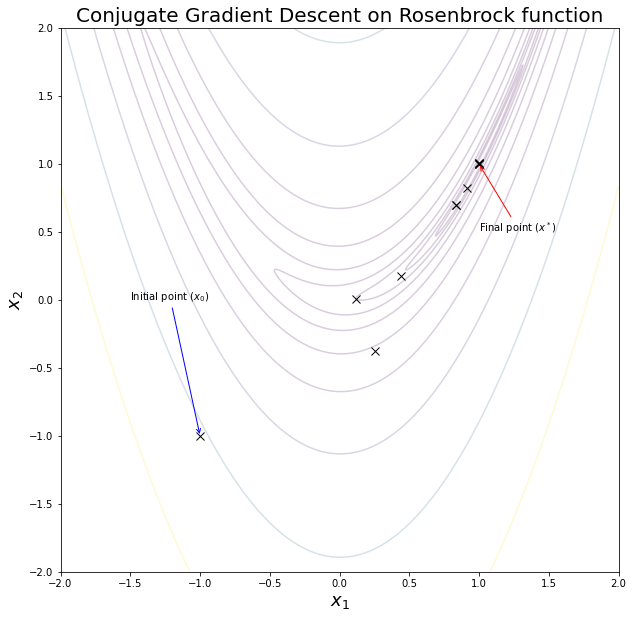

5457

In [14]:
plot_descent(title="Conjugate Gradient Descent", x0=np.array([-1, -1]), f=rosenbrock, f_grad=rosenbrock_grad, descent_method=ConjugateGradientDescent)
gc.collect()

#### Momentum
* Page 75 (Algorithm 5.3)

In [15]:
class Momentum(FirstOrderDescentMethod):
    def __init__(self, f, f_grad, x, alpha, beta):
        self.alpha = alpha
        self.beta = beta
        self.velocity = np.zeros(len(x))
        
    def step(self, f, f_grad, x):
        alpha, beta, v, g = self.alpha, self.beta, self.velocity, f_grad(x)
        self.velocity = beta * v - alpha * g
        return x + v

[INFO] Estimated time:   0.0098sec;   18 iterations
[INFO] Function value is minimized to: 0.2966
	@ x* = [0.4553931  0.20798146]


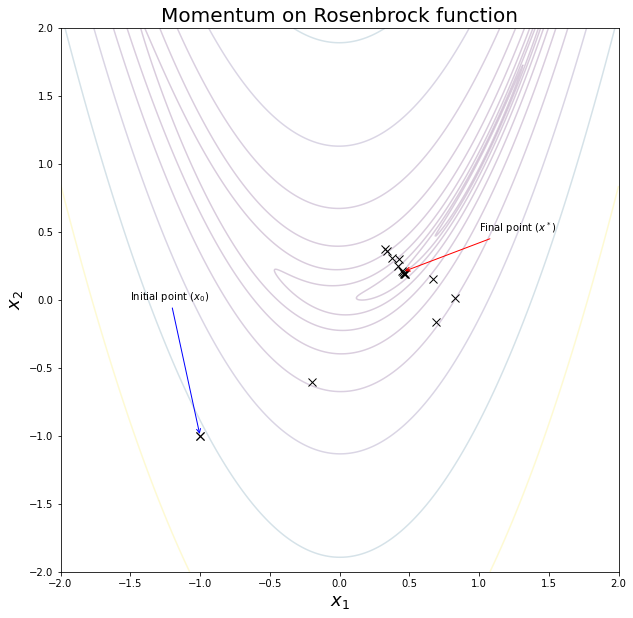

5812

In [16]:
plot_descent(title="Momentum", x0=np.array([-1, -1]), f=rosenbrock, f_grad=rosenbrock_grad, descent_method=Momentum, alpha=0.001, beta=0.1)
gc.collect()

#### Nesterov Momentum
* Page 76 (Algorithm 5.4)

In [17]:
class NesterovMomentum(FirstOrderDescentMethod):
    def __init__(self, f, f_grad, x, alpha, beta):
        self.alpha = alpha
        self.beta = beta
        self.velocity = np.zeros(len(x))
        
    def step(self, f, f_grad, x):
        alpha, beta, v = self.alpha, self.beta, self.velocity
        self.velocity = beta * v - alpha * f_grad(x + beta * v)
        return x + v

[INFO] Estimated time:   0.0081sec;   15 iterations
[INFO] Function value is minimized to: 0.3431
	@ x* = [0.42239008 0.16867027]


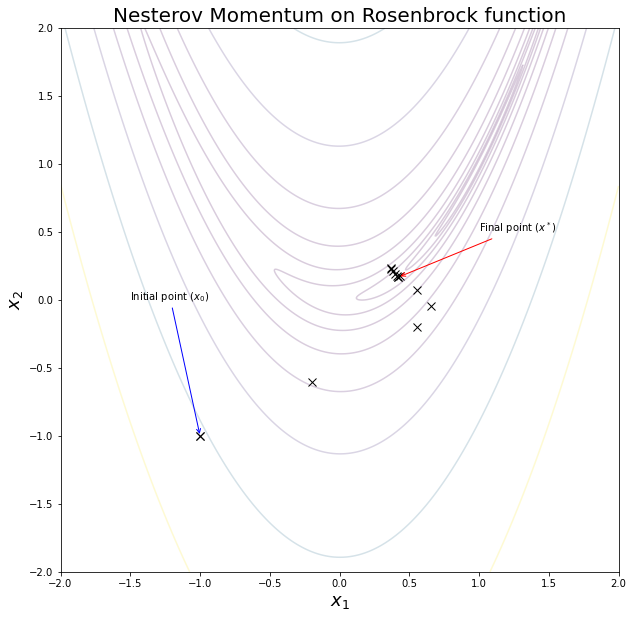

5912

In [18]:
plot_descent(title="Nesterov Momentum", x0=np.array([-1, -1]), f=rosenbrock, f_grad=rosenbrock_grad, descent_method=NesterovMomentum, alpha=0.001, beta=0.1)
gc.collect()

#### Adagrad
* Page 78 (Algorithm 5.5)

In [19]:
class Adagrad(FirstOrderDescentMethod):
    def __init__(self, f, f_grad, x, alpha, epsilon):
        self.alpha = alpha
        self.epsilon = epsilon
        self.ssg = np.zeros(len(x))
        
    def step(self, f, f_grad, x):
        alpha, epsilon, s, g = self.alpha, self.epsilon, self.ssg, f_grad(x)
        self.ssg += g * g 
        return x - alpha * g / (np.sqrt(s) + epsilon)

[INFO] Estimated time:   0.0008sec;    2 iterations
[INFO] Function value is minimized to: 0.0000
	@ x* = [1. 1.]


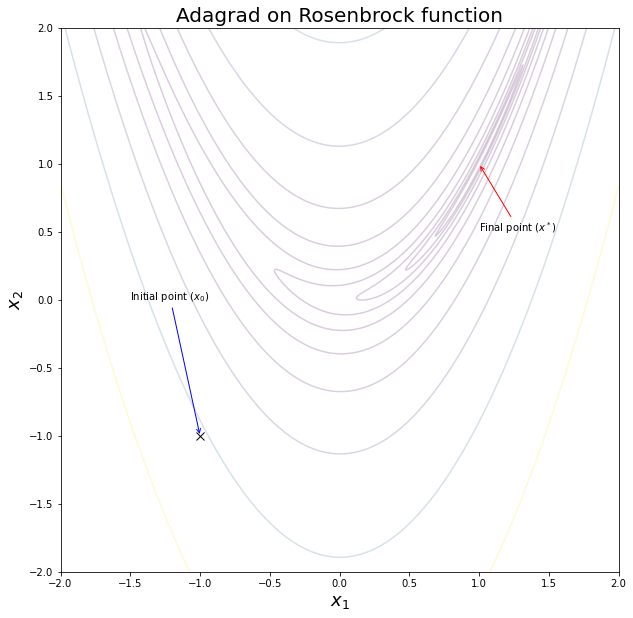

4815

In [20]:
plot_descent(title="Adagrad", x0=np.array([-1, -1]), f=rosenbrock, f_grad=rosenbrock_grad, descent_method=Adagrad, alpha=2.0, epsilon=1e-8)
gc.collect()

#### RMSProp
* Page 79 (Algorithm 5.6)

In [21]:
class RMSProp(FirstOrderDescentMethod):
    def __init__(self, f, f_grad, x, alpha, gamma, epsilon):
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.ssg = np.zeros(len(x))
        
    def step(self, f, f_grad, x):
        alpha, gamma, epsilon, s, g = self.alpha, self.gamma, self.epsilon, self.ssg, f_grad(x)
        self.ssg += gamma * g + (1 - gamma) * (g * g)
        return x - alpha * g / (np.sqrt(s) + epsilon)

[INFO] Estimated time:   0.0125sec;   22 iterations
[INFO] Function value is minimized to: 0.0772
	@ x* = [0.72233275 0.52253379]


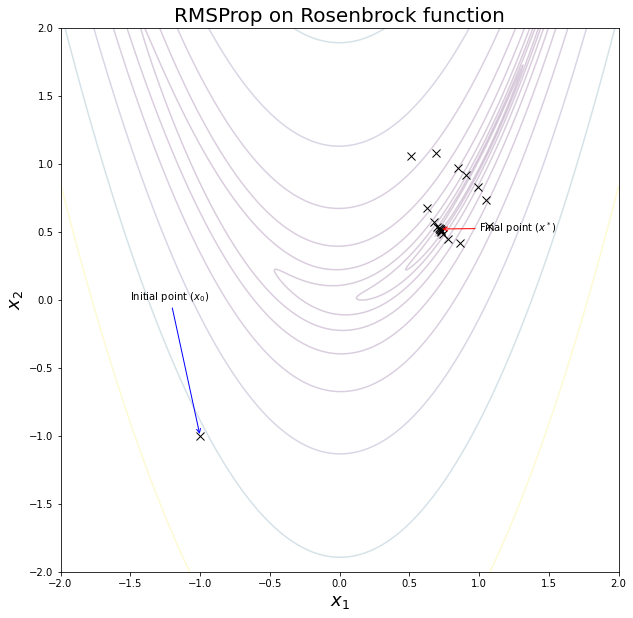

5981

In [22]:
plot_descent(title="RMSProp", x0=np.array([-1, -1]), f=rosenbrock, f_grad=rosenbrock_grad, descent_method=RMSProp, alpha=0.6, gamma=0.9, epsilon=1e-8)
gc.collect()

#### Adadelta
* Page 80 (Algorithm 5.7)

In [23]:
class Adadelta(FirstOrderDescentMethod):
    def __init__(self, f, f_grad, x, gammas, gammax, epsilon):
        self.gammas = gammas
        self.gammax = gammax
        self.epsilon = epsilon
        self.ssg = np.zeros(len(x))
        self.ssu = np.zeros(len(x))
        
    def step(self, f, f_grad, x):
        gammas, gammax, epsilon, s, u, g = self.gammas, self.gammax, self.epsilon, self.ssg, self.ssu, f_grad(x)
        self.ssg = gammas * s + (1 - gammas) * (g * g)
        delta = - (np.sqrt(u) + epsilon) / (np.sqrt(self.ssg) + epsilon) * g
        self.ssu = gammax * u + (1 - gammax) * (delta * delta)
        return x + delta

[INFO] Estimated time:   0.0025sec;    5 iterations
[INFO] Function value is minimized to: 1.1650
	@ x* = [-0.07931382  0.0071428 ]


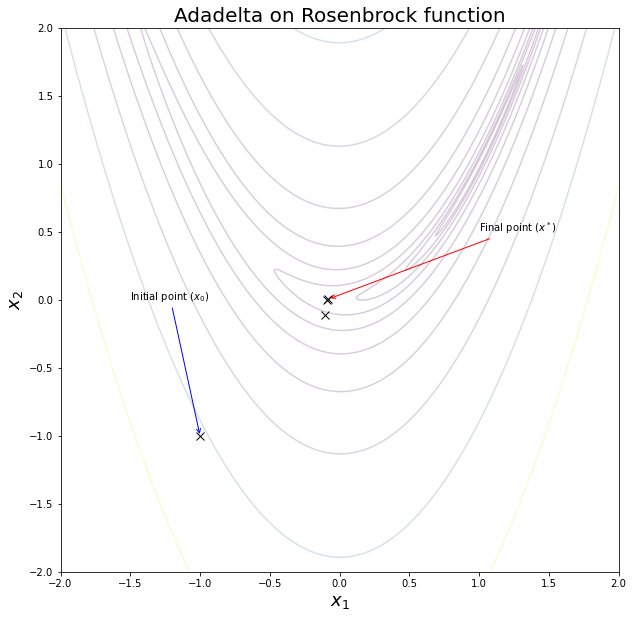

4960

In [24]:
plot_descent(title="Adadelta", x0=np.array([-1, -1]), f=rosenbrock, f_grad=rosenbrock_grad, descent_method=Adadelta, gammas=0.95, gammax=0.95, epsilon=0.2)
gc.collect()

#### Adam
* Page 81 (Algorithm 5.8)

In [25]:
class Adam(FirstOrderDescentMethod):
    def __init__(self, f, f_grad, x, alpha, gammav, gammas, epsilon):
        self.alpha = alpha
        self.gammav = gammav
        self.gammas = gammas
        self.epsilon = epsilon
        self.k = 0
        self.v = np.zeros(len(x))
        self.s = np.zeros(len(x))
        
    def step(self, f, f_grad, x):
        alpha, gammav, gammas, epsilon = self.alpha, self.gammav, self.gammas, self.epsilon
        s, v, g = self.s, self.v, f_grad(x)
        self.v = gammav * v + (1 - gammav) * g
        self.s = gammas * s + (1 - gammas) * g * g
        self.k  += 1
        v_hat = v / (1 - gammav**self.k)
        s_hat = s / (1 - gammas**self.k)
        return x - alpha * v_hat / (np.sqrt(s_hat) + epsilon)

[INFO] Estimated time:   0.0379sec;   64 iterations
[INFO] Function value is minimized to: 0.7471
	@ x* = [0.51765019 0.33968747]


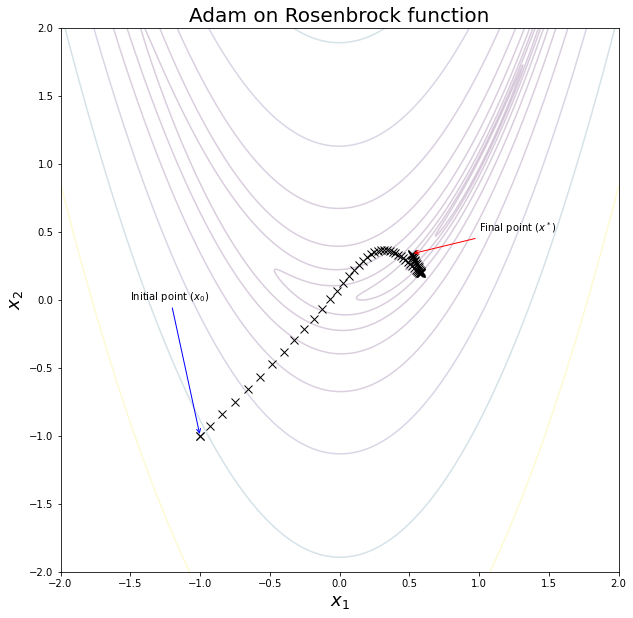

8488

In [26]:
plot_descent(title="Adam", x0=np.array([-1, -1]), f=rosenbrock, f_grad=rosenbrock_grad, descent_method=Adam, alpha=0.1, gammav=0.9, gammas=0.999, epsilon=1e-8)
gc.collect()

#### Hypergradient descent
* Page 83 (Algorithm 5.9)

In [27]:
class HyperGradientDescent(FirstOrderDescentMethod):
    def __init__(self, f, f_grad, x, alpha0, mu):
        self.alpha = alpha0
        self.mu = mu
        self.g_prev = np.zeros(len(x))
        
    def step(self, f, f_grad, x):
        alpha, mu, g, g_prev = self.alpha, self.mu, f_grad(x), self.g_prev
        alpha = alpha + mu * np.dot(g, g_prev)
        self.g_prev, self.alpha = g, alpha
        return x - alpha * g

[INFO] Estimated time:   0.0061sec;   11 iterations
[INFO] Function value is minimized to: 0.4580
	@ x* = [0.32542032 0.10047951]


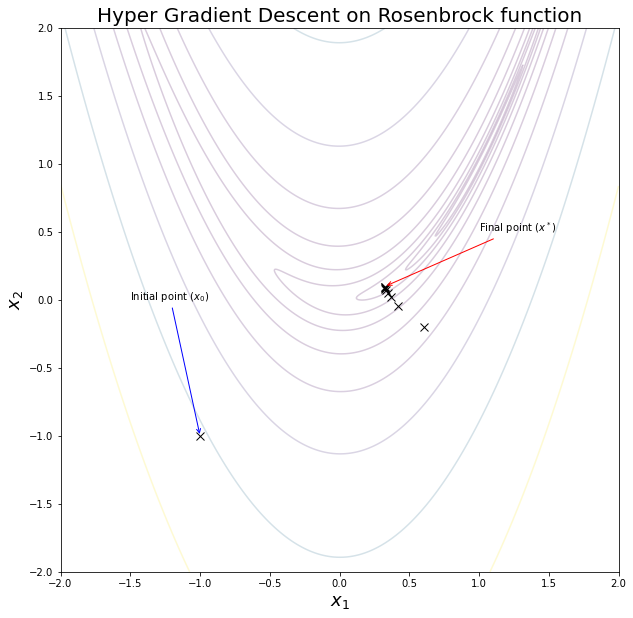

4710

In [28]:
plot_descent(title="Hyper Gradient Descent", x0=np.array([-1, -1]), f=rosenbrock, f_grad=rosenbrock_grad, descent_method=HyperGradientDescent, alpha0=0.002, mu=1e-8)
gc.collect()

#### Hypergradient Nesterov momentum
* Page 83 (Algorithm 5.9)

In [29]:
class HyperNesterovMomentum(FirstOrderDescentMethod):
    def __init__(self, f, f_grad, x, alpha0, mu, beta):
        self.alpha = alpha0
        self.mu = mu
        self.beta = beta
        self.v = np.zeros(len(x))
        self.g_prev = np.zeros(len(x))
        
    def step(self, f, f_grad, x):
        alpha, beta, mu = self.alpha, self.beta, self.mu
        v, g, g_prev = self.v, f_grad(x), self.g_prev
        alpha = alpha - mu * (np.dot(g, (-g_prev - beta * v)))
        self.v = beta * v + g
        self.g_prev, self.alpha = g, alpha
        return x - alpha * (g + beta * v)

[INFO] Estimated time:   0.0055sec;   10 iterations
[INFO] Function value is minimized to: 0.4502
	@ x* = [0.33215274 0.10384473]


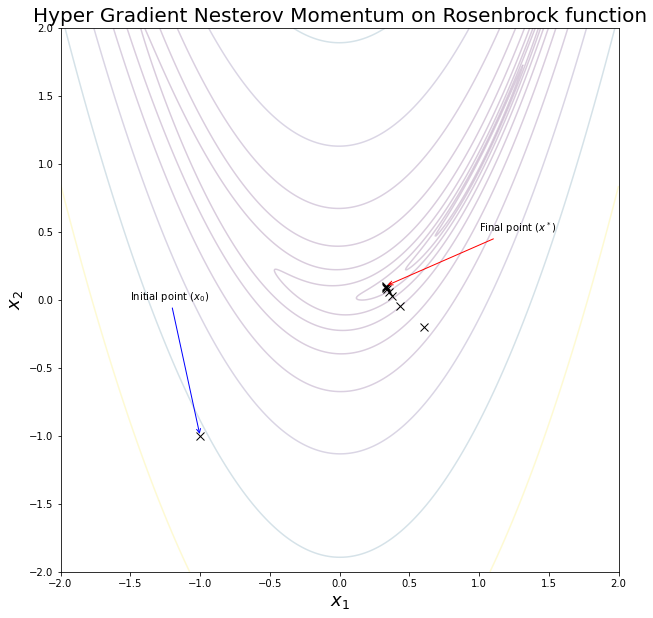

5298

In [30]:
plot_descent(title="Hyper Gradient Nesterov Momentum", x0=np.array([-1, -1]), f=rosenbrock, f_grad=rosenbrock_grad, descent_method=HyperNesterovMomentum, alpha0=0.002, mu=1e-8, beta=0.01)
gc.collect()